In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import random

from fine_tuning.pretrained_models.bisonai.models import OmniglotModelBisonai

In [2]:
### Parameters

num_classes = 3
learning_rate = 0.001
epochs = 5
checkpoint_path = "fine_tuning/pretrained_models/bisonai/1shot_3way_bisonai_ckpt_o15t/model.ckpt-99999"

def softmax(x):
    e = np.exp(x)
    return (e / np.sum(e, axis=1, keepdims=True))

## Data for fine-tuning & prediction

In [3]:
sess = tf.Session()

mnist_train = tfds.load(name="mnist", split=tfds.Split.TRAIN).batch(2000)
mnist_example = mnist_train.take(1)
mnist_example_iter = mnist_example.make_initializable_iterator()
sess.run(mnist_example_iter.initializer)

data = mnist_example_iter.get_next()
image = data['image']
label = data['label']
x, y = sess.run([image,label])

X_train = np.array(1-x[:num_classes,:,:,:]/255.0).reshape(3, 28, 28, 1)
y_train = np.array(y[:num_classes])

print(X_train.shape)
print(y_train.shape)

(3, 28, 28, 1)
(3,)


In [4]:
y_train

array([8, 8, 9])

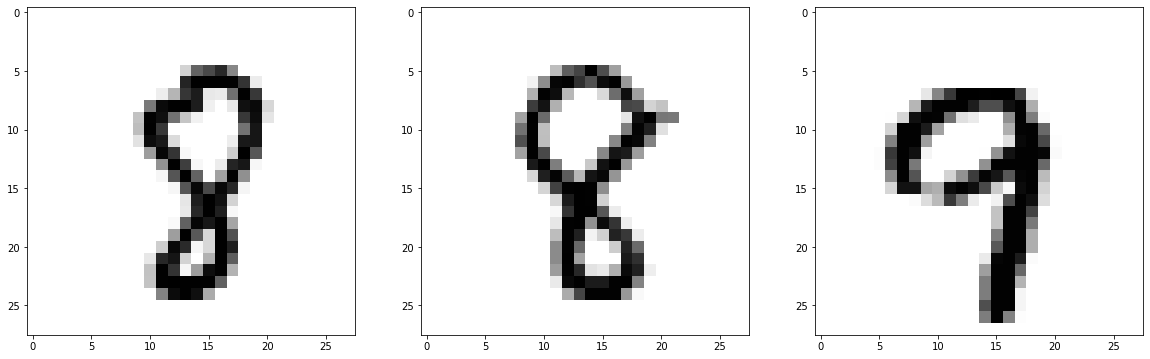

In [5]:
### Showing Images of the 3 classes after reshape 28x28x1

plt.figure(figsize=(20,20))
plt.subplot(131)
imgplot = plt.imshow(X_train[0,:,:,0], cmap="gist_gray")
plt.subplot(132)
imgplot = plt.imshow(X_train[1,:,:,0], cmap="gist_gray")
plt.subplot(133)
imgplot = plt.imshow(X_train[2,:,:,0], cmap="gist_gray")

In [6]:
res = sum([np.where(y == c)[0].tolist() for c in y_train], [])
[res.remove(i) for i in range(num_classes)]

ind = random.choice(res)
X_predict = np.array(1-x[ind,:,:,0]/255.0).reshape((1, 28, 28,1))
y_predict = y[ind]

print(X_predict.shape)

(1, 28, 28, 1)


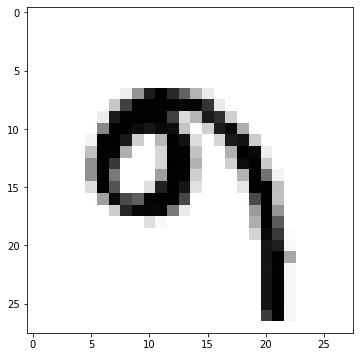

In [7]:
###### Showing the image with class to predict

plt.figure(figsize=(6,6))
imgplot = plt.imshow(X_predict[0,:,:,0], cmap="gist_gray")

## Preparing the model & prediction

In [8]:
model = OmniglotModelBisonai(num_classes=3, **{'learning_rate':learning_rate})
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

for i in tf.all_variables():
    if "Adam_1" in i.name:
        sess.run(tf.assign(i,i/(tf.sqrt(i) + 1e-5)))

In [9]:
y_train_label = np.array([0, 1, 2])

adam_var = [i for i in tf.all_variables() if "Adam_1" in i.name]

for e in range(epochs):
#     grad_temp, logits, loss, _ = sess.run([tf.gradients(model.loss, tf.trainable_variables()), model.logits, model.loss, tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)], feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
#     #print(grad_temp)
#     print("softmax", softmax(logits))
#     print("loss", np.sum(loss))
#     for i,j,k in zip(tf.trainable_variables(), grad_temp, adam_var):
#         sess.run(tf.assign(i,i-j*k*learning_rate))
#         #print(sess.run(j*k*learning_rate))
    
#     logits = sess.run(model.logits, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})
#     print("test softmax", softmax(logits))

    loss = sess.run(model.loss, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
    print("loss", loss)

    logits = sess.run(model.logits, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})
    print("test softmax", softmax(logits))
    sess.run(model.minimize_op, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph:y_train_label})


result, logits = sess.run([model.predictions, model.logits], feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})

print("The result is {}.".format(y_train[result[0]]))
print("The probability distribution is {}.".format(softmax(logits)))

loss [1.3987695 1.1932373 1.1439003]
test softmax [[0.33931908 0.316338   0.34434298]]
loss [0.00219022 0.00876449 0.00303356]
test softmax [[0.30515462 0.31902808 0.37581736]]
loss [0.00214252 0.00798782 0.00291542]
test softmax [[0.3056008  0.31861418 0.375785  ]]
loss [0.002096   0.00733563 0.00280749]
test softmax [[0.30599657 0.31819835 0.37580502]]
loss [0.00205008 0.00677893 0.00270893]
test softmax [[0.30637172 0.3178309  0.37579736]]
The result is 9.
The probability distribution is [[0.30670717 0.31746    0.37583283]].
